In [1]:

suppressMessages(library(tidyverse))
suppressMessages(library(parallel))
suppressMessages(library(Seurat))
suppressMessages(library(SeuratData))
suppressMessages(library(patchwork))
suppressMessages(library(Matrix))
suppressMessages(library(viridis))
suppressMessages(library(cowplot))
suppressMessages(library(ggsci))
suppressMessages(library(pheatmap))
suppressMessages(library(RColorBrewer))
suppressMessages(library(reshape2))
suppressMessages(library(LSD))
suppressMessages(library(readxl))
suppressMessages(library(ggrepel))
suppressMessages(library(randomForest))
suppressMessages(library(harmony))

# Plot each clusters
myHighlightDimPlot = function(seuratObj, highlightBy, size=1, alpha=1, showAllPoints=FALSE, ...) {
    umapTb = as_tibble(seuratObj@reductions$umap@cell.embeddings)
    if (!identical(rownames(seuratObj@reductions$umap@cell.embeddings), rownames(seuratObj@meta.data)))
        stop("Error: cell names not identical!")
    umapTb = cbind(umapTb, seuratObj@meta.data)
    highlightByClass = sort(unique(umapTb[[highlightBy]]))
    gpList = lapply(highlightByClass, function(cl) {
        subUmapTb = subset(umapTb, umapTb[[highlightBy]] == cl)
        if (showAllPoints) {
            gp = ggplot() + 
                geom_point(data=umapTb, aes(x=UMAP_1, y=UMAP_2), color="grey", shape=16, size=size, alpha=alpha) +
                geom_point(data=subUmapTb, aes(x=UMAP_1, y=UMAP_2), color="red", shape=16, size=size, alpha=alpha) +
                xlim(min(umapTb$UMAP_1), max(umapTb$UMAP_1)) +
                ylim(min(umapTb$UMAP_2), max(umapTb$UMAP_2)) +
                coord_fixed() +
                theme_void() 
        } else {
            gp = ggplot() + 
                geom_point(data=umapTb, aes(x=UMAP_1, y=UMAP_2), color="grey", shape=16, size=size, alpha=alpha) +
                geom_point(data=subUmapTb, aes(x=UMAP_1, y=UMAP_2), color="red", shape=16, size=size, alpha=alpha) +
                xlim(min(umapTb$UMAP_1), max(umapTb$UMAP_1)) +
                ylim(min(umapTb$UMAP_2), max(umapTb$UMAP_2)) +
                coord_fixed() +
                theme_void()
        }
        return(gp)
    })
    gpAll = plot_grid(plotlist=gpList, labels=highlightByClass, ...)
    return(gpAll)
}

In [2]:
seurat=readRDS('/home/liuyx/liuyuxuan/spa_seurat/cla/renew_sndata_0619_mouse_mamoset/20230619.cla_snrna/mice/mouse_snrna_all_soupX_unfil_0619.rds')

seurat

An object of class Seurat 
45186 features across 131543 samples within 1 assay 
Active assay: RNA (45186 features, 0 variable features)

In [3]:
table(seurat@meta.data$group)
length(unique(seurat@meta.data$group))


2934-1 2934-2 2934-3 2934-4 2934-5 2934-6 2934-7 2934-8 2934-9 
 66017   8183   8089   8286   8145   8110   8149   8337   8227 

[1] 9

In [4]:
#去除 median nfeature <500
df_meta=seurat@meta.data
group_med_feature=df_meta %>% group_by(group)  %>% summarise(med=median(nFeature_RNA))
select_group=group_med_feature[group_med_feature$med > 500,]$group
#被去掉的文库
length(group_med_feature$group)
group_med_feature[group_med_feature$med < 500,]$group
length(select_group)

seurat=subset(seurat,group %in% select_group)



[1] 9

character(0)

[1] 9

In [5]:
MTGenes = rownames(seurat)[grep('mt',rownames(seurat))]
seurat[["percent.mt"]] <- PercentageFeatureSet(seurat,pattern = MTGenes)



Warning message in grep(pattern = pattern, x = rownames(x = object[[assay]]), value = TRUE):
“argument 'pattern' has length > 1 and only the first element will be used”


In [6]:
# Basic filtering
#修改为200
oriCellNum = ncol(seurat)
seurat$countFeatureRatio = seurat$nCount_RNA / seurat$nFeature_RNA
seurat = subset(seurat, nFeature_RNA > 300 & percent.mt < 5 & countFeatureRatio > 1.2)
cellNum1 = ncol(seurat)
cellNum1
message("Filter ratio: ", cellNum1/oriCellNum)

[1] 131543

Filter ratio: 1



Warning message:
“`guides(<scale> = FALSE)` is deprecated. Please use `guides(<scale> = "none")` instead.”
Warning message:
“`guides(<scale> = FALSE)` is deprecated. Please use `guides(<scale> = "none")` instead.”
Warning message:
“`guides(<scale> = FALSE)` is deprecated. Please use `guides(<scale> = "none")` instead.”
Warning message:
“`guides(<scale> = FALSE)` is deprecated. Please use `guides(<scale> = "none")` instead.”


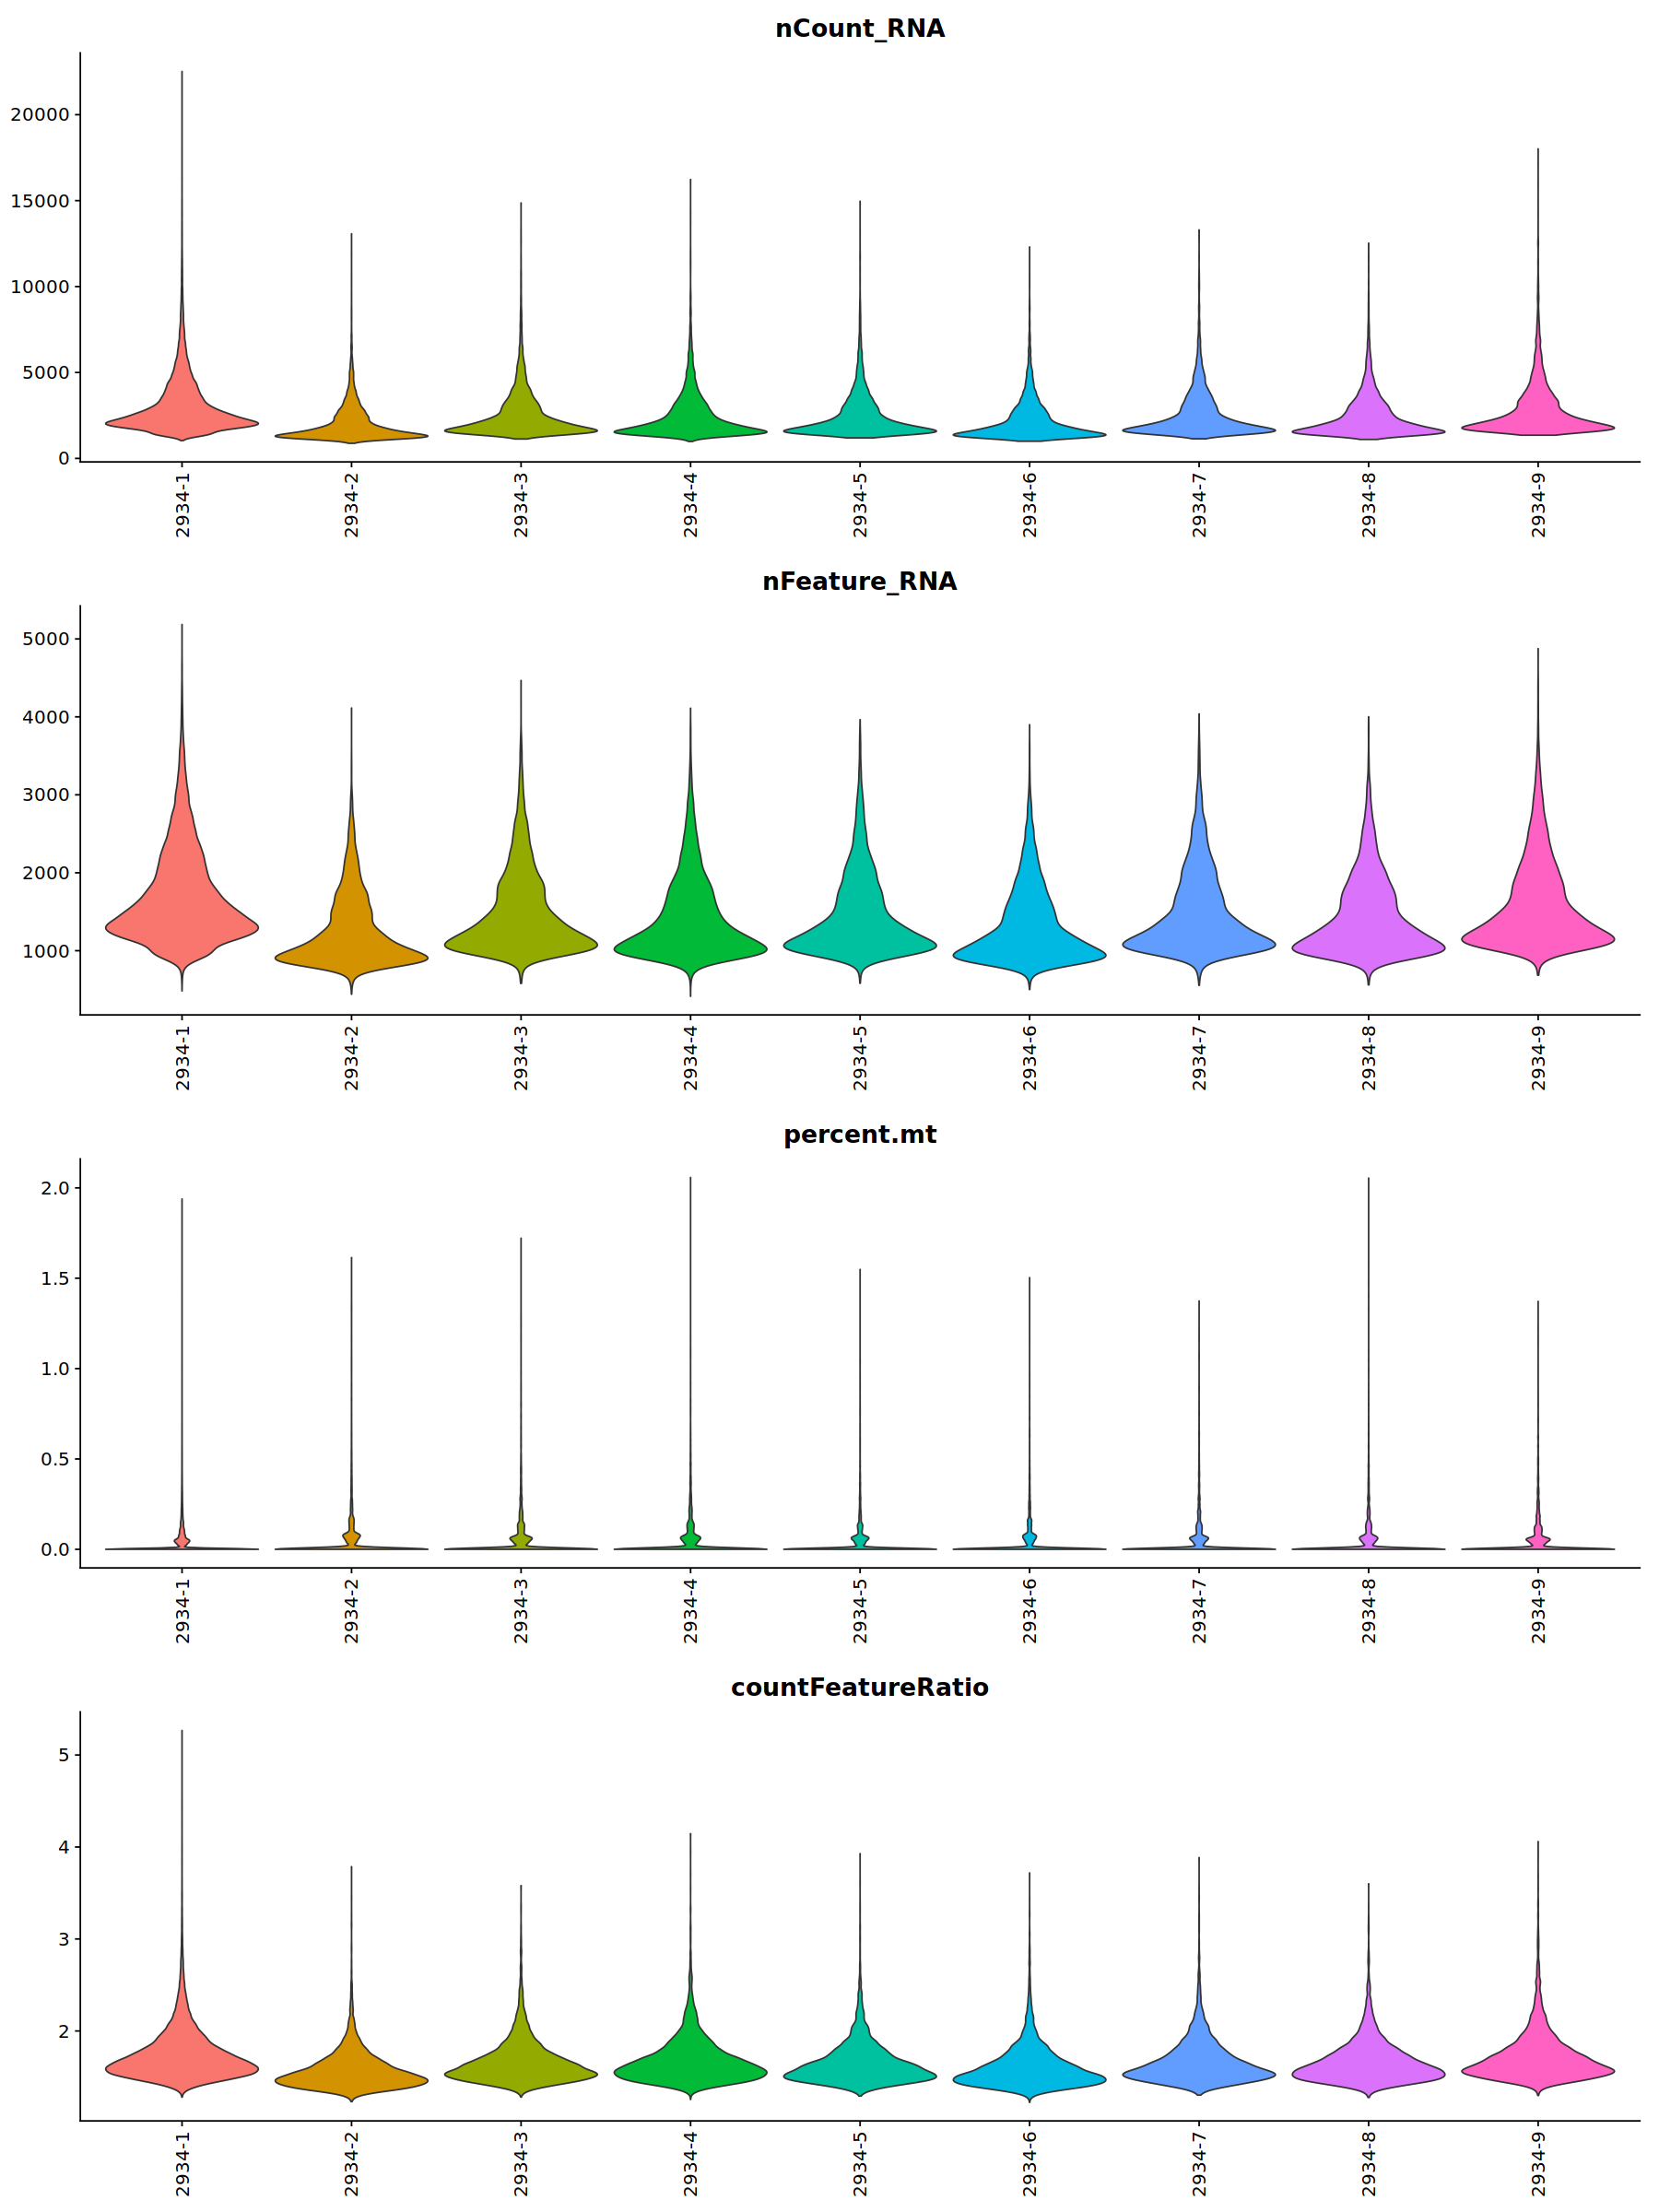

In [7]:
Idents(seurat) = "group"
options(repr.plot.width=15, repr.plot.height=20)
print(plot_grid(
    plotlist = lapply(c("nCount_RNA", "nFeature_RNA", "percent.mt", "countFeatureRatio"), function(x) {
        p = VlnPlot(seurat, features=x, pt.size=0) + 
            theme(axis.text.x=element_text(vjust=0.5, hjust=0.5, angle=90), axis.title.x = element_blank()) +
            guides(fill=FALSE)
        return(p)
    }), 
    ncol=1, align="hv", axis="tblr"
))

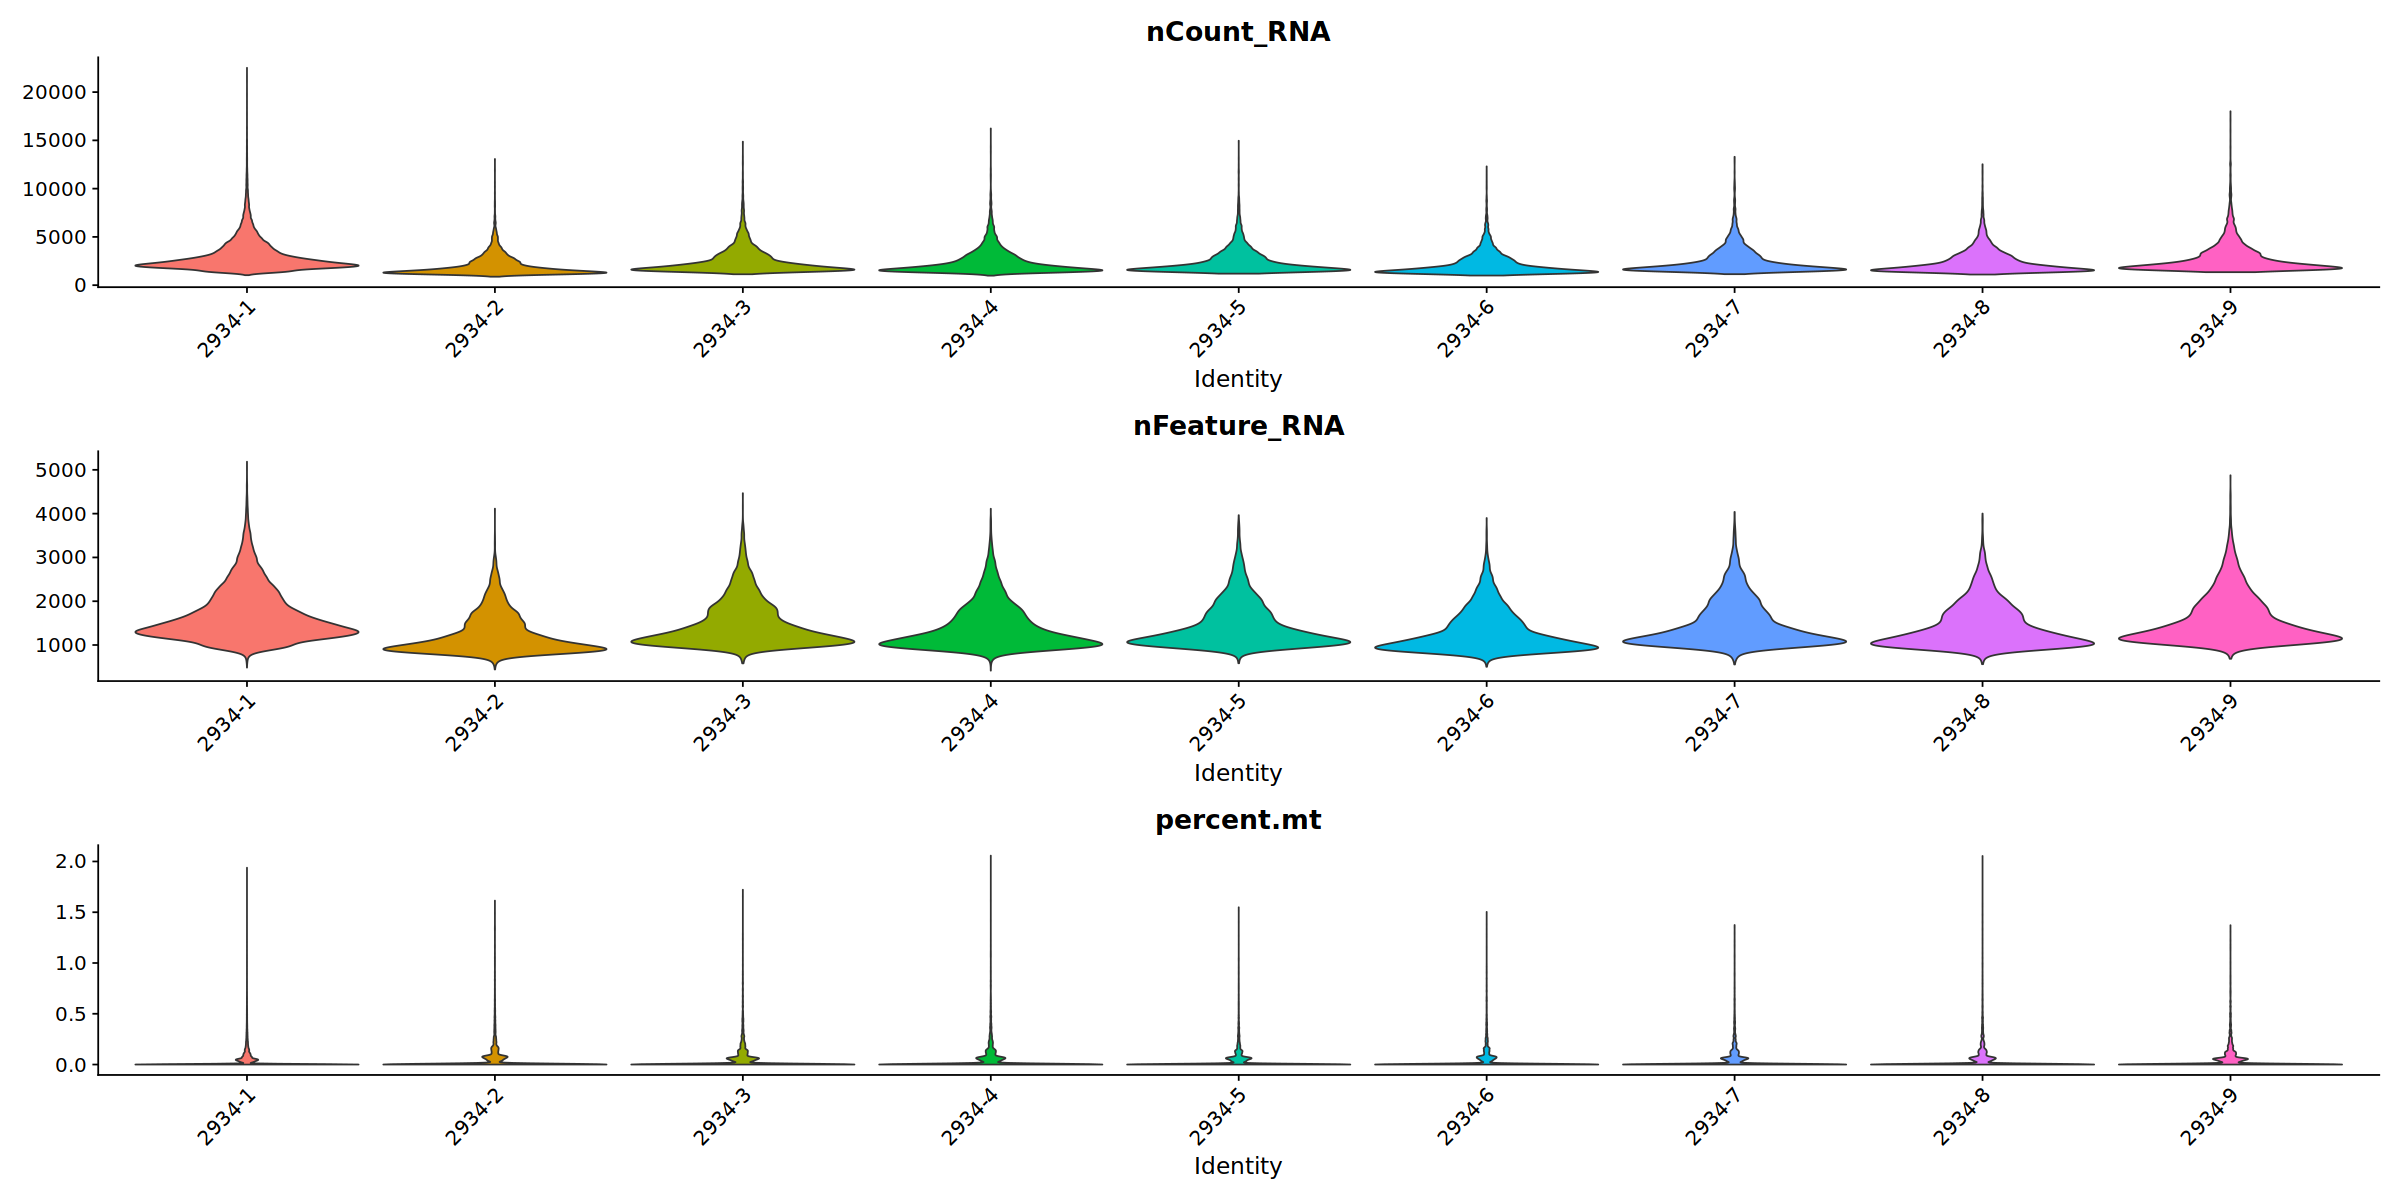

In [8]:
options(repr.plot.width=20, repr.plot.height=10)
Idents(seurat) = "group"
VlnPlot(seurat, features=c("nCount_RNA", "nFeature_RNA", "percent.mt"), pt.size=0, ncol=1)

In [9]:
seurat

An object of class Seurat 
45186 features across 131543 samples within 1 assay 
Active assay: RNA (45186 features, 0 variable features)

In [10]:
#更新为统一版本

saveRDS(seurat,'/home/liuyx/liuyuxuan/spa_seurat/cla/mouse/batch_normalize_renew_1031_mouse/mouse_snrna_all_soupX_fil_batch2_0619.rds')



In [16]:
#原有不正确版本
saveRDS(seurat,'/home/liuyx/liuyuxuan/spa_seurat/cla/mouse/0619snrna_data/mouse_snrna_all_soupX_fil_0619.rds')



In [ ]:
seurat1=readRDS('/home/liuyx/liuyuxuan/spa_seurat/cla/mouse/snrna_data/0523_mouse_data/mouse_snrna_all_soupX_fil800_SCT_0524.rds')
seurat1$batch='batch1'

seurat2=readRDS('/home/liuyx/liuyuxuan/spa_seurat/cla/mouse/0619snrna_data/mouse_snrna_all_soupX_fil_0619.rds')
seurat2$batch='batch2'

classFiltSeurat=merge(seurat1,seurat2)
classFiltSeurat

# Do sct together
classFiltSeurat = SCTransform(
    classFiltSeurat, assay="RNA",
    ncells=ncol(classFiltSeurat[["RNA"]]),
    variable.features.n=5000,
    vars.to.regress="percent.mt",
    return.only.var.genes = T,
    method="glmGamPoi"
)
classFiltSeurat = classFiltSeurat %>%
    RunPCA(npcs=100, verbose = FALSE) %>%
    FindNeighbors(dims = 1:50) %>%
    FindClusters(verbose = FALSE) %>%
    RunUMAP(dims = 1:50)

saveRDS(classFiltSeurat,paste0('/home/liuyx/liuyuxuan/spa_seurat/cla/mouse/0619snrna_data', "/mouse_snrna_all_soupX_fil800_SCT_0619_0524_anno_SCT.rds"))




In [25]:
seurat=readRDS(paste0('/home/liuyx/liuyuxuan/spa_seurat/cla/mouse/0619snrna_data', "/mouse_snrna_all_soupX_fil800_SCT_0619_0524_anno_SCT.rds"))



In [28]:
seurat@meta.data

,orig.ident,nCount_RNA,nFeature_RNA,group,libId,sampleId,percent.mt,countFeatureRatio,nCount_SCT,nFeature_SCT,SCT_snn_res.0.8,seurat_clusters,batch
,<chr>,<dbl>,<int>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<int>,<fct>,<fct>,<chr>
2191-1_CELL6894_N1,SeuratProject,2869,1799,2191-1,2191-1,NA,0.00000000,1.594775,3016,1799,32,32,batch1
2191-1_CELL2974_N1,SeuratProject,5212,2840,2191-1,2191-1,NA,0.00000000,1.835211,4080,2840,9,9,batch1
2191-1_CELL39_N2,SeuratProject,21400,5431,2191-1,2191-1,NA,0.06542056,3.940342,3578,2248,8,8,batch1
2191-1_CELL4337_N1,SeuratProject,4084,2344,2191-1,2191-1,NA,0.12242899,1.742321,3899,2344,7,7,batch1
2191-1_CELL4465_N1,SeuratProject,3788,2266,2191-1,2191-1,NA,0.02639916,1.671668,3754,2266,9,9,batch1
2191-1_CELL2955_N1,SeuratProject,5282,2643,2191-1,2191-1,NA,0.00000000,1.998487,4038,2642,4,4,batch1
2191-1_CELL1969_N1,SeuratProject,8749,3647,2191-1,2191-1,NA,0.02285976,2.398958,3610,2295,17,17,batch1
2191-1_CELL1845_N1,SeuratProject,10675,4296,2191-1,2191-1,NA,0.04683841,2.484870,3384,2193,23,23,batch1
2191-1_CELL3735_N1,SeuratProject,4322,2354,2191-1,2191-1,NA,0.00000000,1.836024,3987,2354,7,7,batch1


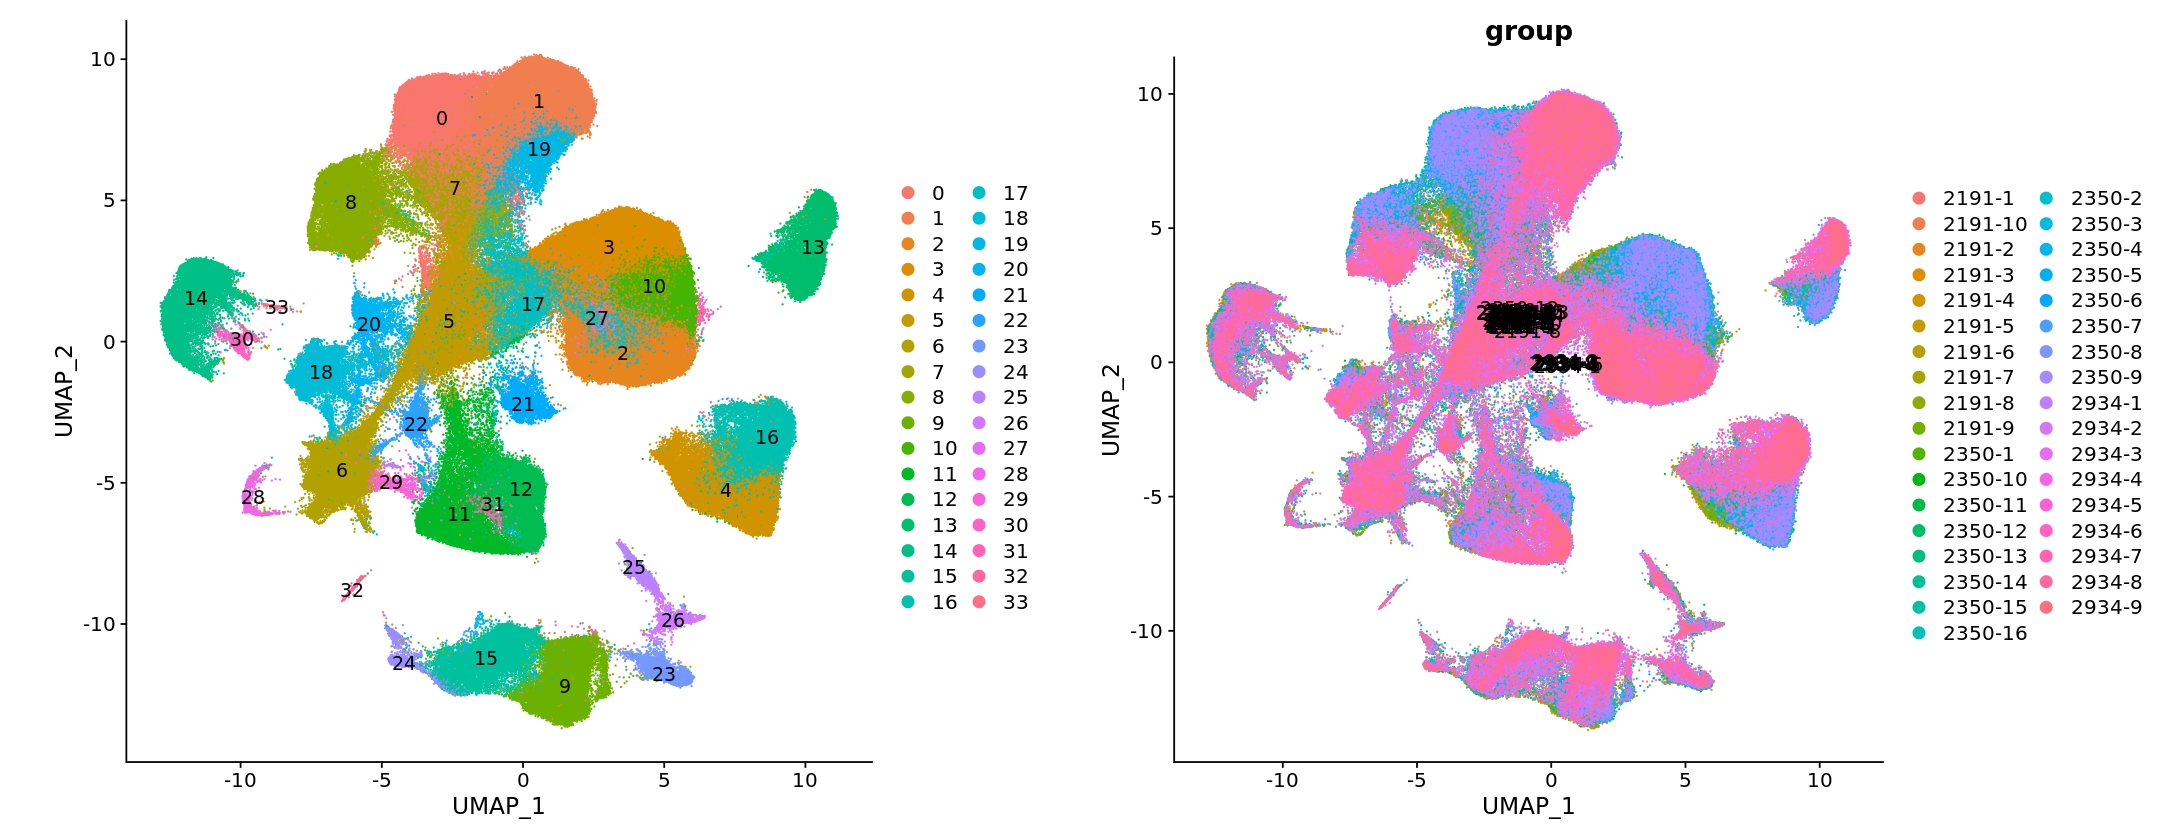

In [29]:
options(repr.plot.width=18, repr.plot.height=7)
plot_grid(
    DimPlot(seurat, reduction="umap", label=T,raster=FALSE)+coord_fixed(),
    #DimPlot(seurat, reduction="umap", group.by="sampleId", label=T)+coord_fixed(),
    DimPlot(seurat, reduction="umap", group.by="group", label=T,raster=FALSE)+coord_fixed(),
    nrow=1
)

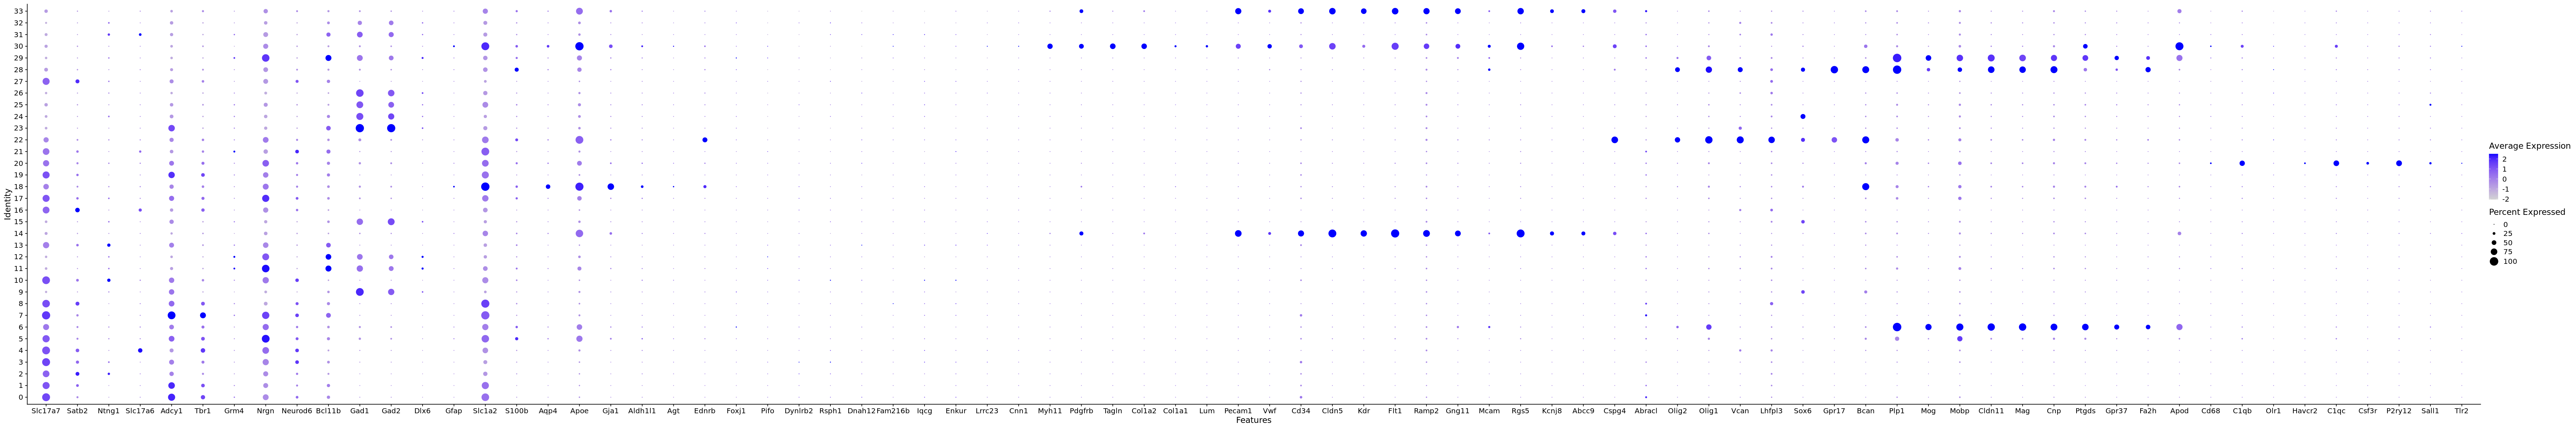

In [30]:
selectMarkers = c(
    "SLC17A7","SATB2",'NTNG1','SLC17A6','ADCY1','TBR1','GRM4','NRGN','NEUROD6','BCL11B', # Excit
    "GAD1", "GAD2",'DLX6','DLX6-AS1', # Inhib,
    "GFAP", "SLC1A2", "SLC1A2", "S100B", "AQP4", "APOE",'GJA1','ALDH1L1','AGT','EDNRB', # Astrocytes
    "FOXJ1", "PIFO", "DYNLRB2", "RSPH1", "DNAH12", "FAM216B", "ZMYDN10", "IQCG", "ENKUR","LRRC23", # Ependymal
    "CNN1", "MYH11", "PDGFRB", "TAGLN", "ALPHA-SMA", # VSMC
    "COL1A2", 'COL1A1','LUM','PDGFRALPHA',# VLMC
    "PECAM1","VWF","CD34","VECAD" ,"CLDN5","KDR","CD105",'FLT1','RAMP2','GNG11',# Endotheial
    "PDGFRB", "MCAM", "RGS5", "ALPHA-SMA", "KCNJ8",'TAGLN','COX4l2','MOTCH3','ABCC9','CSPG4', # Pericytes
    "ABRACL", "PDGFRALPHA", "OLIG2", "CSPG4", "OLIG1", "VCAN",'LHFPL3','SOX6','GPR17','BCAN', # OPC
    "PLP1",'MOG','MOBP','CLDN11','MAG','CNP','PTGDS','GPR37','FA2H','APOD', # Oligo
    'CD68','C1QB','OLR1','HAVCR2','C1QC','CSF3R','CS3CR1','P2RY12','SALL1','TLR2'# Microglia
)


selectMarkers=str_to_title(selectMarkers)

selectMarkers=selectMarkers[!duplicated(selectMarkers)]

options(repr.plot.height=10,repr.plot.width=60)
DotPlot(seurat, features = selectMarkers)





In [32]:
seurat@meta.data$class='Uncertain'
seurat@meta.data[seurat@meta.data$seurat_clusters %in% c(0,1,2,3,4,5,7,8,10,13,16,17,19,20,21,27),]$class='Excit_Neuron'
seurat@meta.data[seurat@meta.data$seurat_clusters %in% c(9,15,23,24,25,26),]$class='Inhibit_Neuron'
seurat@meta.data[seurat@meta.data$seurat_clusters %in% c(18),]$class='Astrocytes'
seurat@meta.data[seurat@meta.data$seurat_clusters %in% c(6,28,29),]$class='Oligo'
seurat@meta.data[seurat@meta.data$seurat_clusters %in% c(14,30,33),]$class='Endotheial'
seurat@meta.data[seurat@meta.data$seurat_clusters %in% c(22),]$class='OPC'
seurat@meta.data[seurat@meta.data$seurat_clusters %in% c(20),]$class='Microglia'



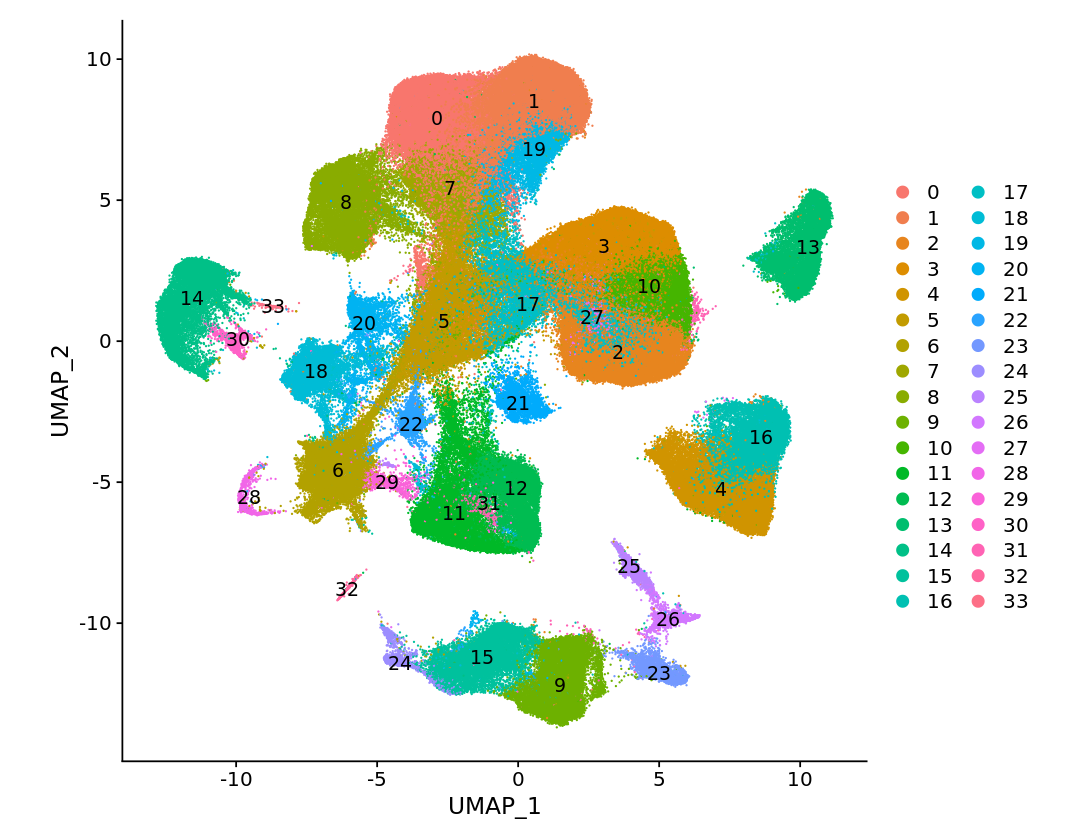

In [31]:
df_test=seurat@reductions$umap@cell.embeddings
df_test=as.data.frame(df_test)
df_test$X=rownames(df_test)

df_meta=seurat@meta.data
df_meta=as.data.frame(df_meta)
df_meta$X=rownames(df_meta)
df_meta=df_meta[,c('nFeature_RNA','X','seurat_clusters')]

df_test=left_join(df_test,df_meta,by='X')


Idents(seurat) = "seurat_clusters"
options(repr.plot.width=9, repr.plot.height=7)
DimPlot(seurat, reduction="umap", label=T,raster=FALSE)+coord_fixed()


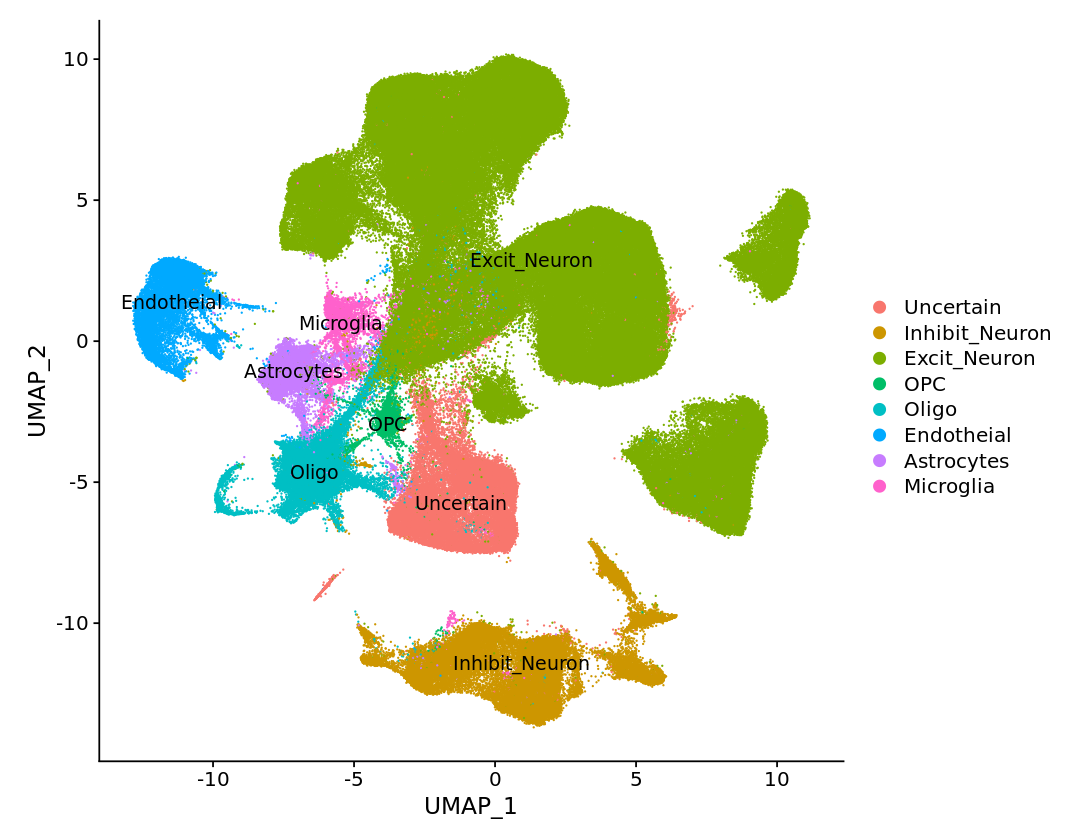

In [33]:
Idents(seurat) = "class"
options(repr.plot.width=9, repr.plot.height=7)
DimPlot(seurat, reduction="umap", label=T,raster=FALSE)+coord_fixed()

In [34]:
# 每个class抽样80%，最多500个细胞
sampleRatio = 0.8
maxCell = 5000
sampleDf = seurat@meta.data[, c("class"), drop=F]
sampleList = split(sampleDf, sampleDf$class)
sampleList = lapply(sampleList, function(x) {
    sampleSize = as.integer(nrow(x)*0.8)
    if (sampleSize > maxCell) {
        sampleSize = maxCell
    }
    sampleIdx = 1:nrow(x)
    sampleIdx = sample(1:nrow(x), size=sampleSize, replace=F)
    return(x[sampleIdx,,drop=F])
})
sampleDf = Reduce(rbind, sampleList)
str(sampleDf)
table(sampleDf$class)

trainSeurat = seurat[,rownames(sampleDf)]
table(trainSeurat$class)

'data.frame':	36222 obs. of  1 variable:
 $ class: chr  "Astrocytes" "Astrocytes" "Astrocytes" "Astrocytes" ...



    Astrocytes     Endotheial   Excit_Neuron Inhibit_Neuron      Microglia 
          5000           5000           5000           5000           3680 
         Oligo            OPC      Uncertain 
          5000           2542           5000 


    Astrocytes     Endotheial   Excit_Neuron Inhibit_Neuron      Microglia 
          5000           5000           5000           5000           3680 
         Oligo            OPC      Uncertain 
          5000           2542           5000 

In [35]:
Idents(trainSeurat) = "class"
classMarker = FindAllMarkers(trainSeurat)
#write_tsv(classMarker, paste0(dataDir, "/allSnRNAseq.soupx.mergeSeuratFiltlibFilt800mt5Ratio1d2.downsample5000ClassMarker.20220822.tsv"))


Calculating cluster Astrocytes

Calculating cluster Endotheial

Calculating cluster Excit_Neuron

Calculating cluster Inhibit_Neuron

Calculating cluster Microglia

Calculating cluster Oligo

Calculating cluster OPC

Calculating cluster Uncertain




    Astrocytes     Endotheial   Excit_Neuron Inhibit_Neuron      Microglia 
            33            167              2             28             15 
         Oligo            OPC      Uncertain 
            28             19             49 

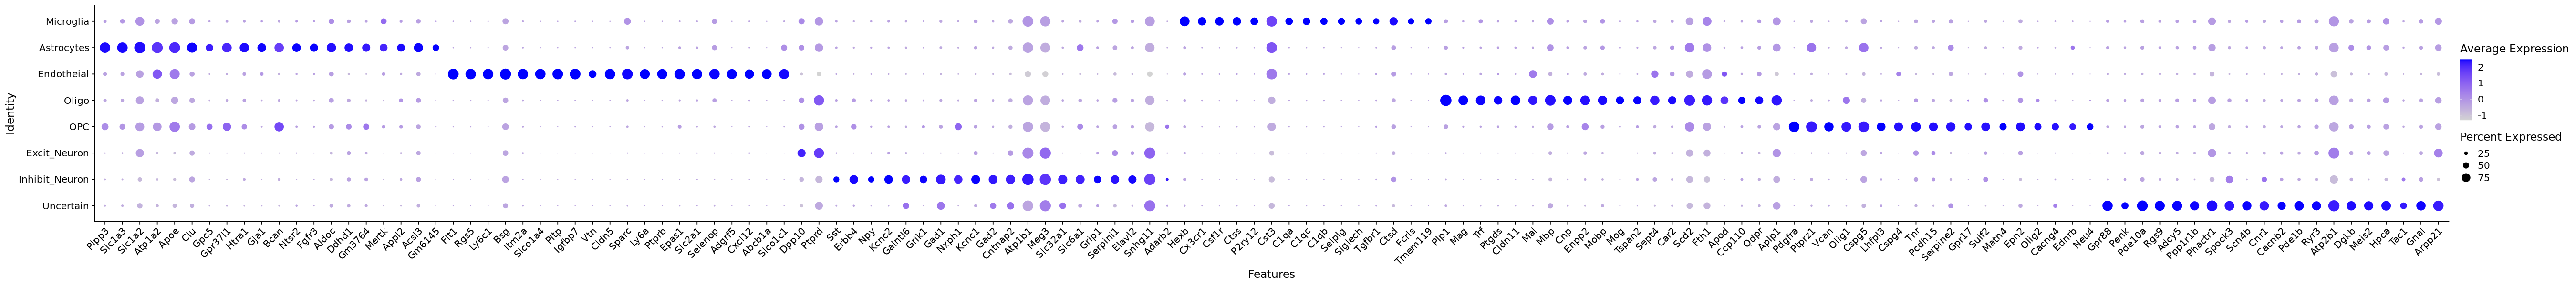

In [36]:
#classMarker = read_tsv(paste0(dataDir, "/allSnRNAseq.soupx.mergeSeuratFiltlibFilt800mt5Ratio1d2.downsample5000ClassMarker.20220822.tsv"))
classMarker = subset(classMarker, p_val_adj < 0.01 & avg_log2FC > 1)
table(classMarker$cluster)

classMarkerTop = classMarker %>% group_by(cluster) %>% top_n(n = 20, wt = avg_log2FC)
options(repr.plot.width=length(unique(classMarkerTop$gene))/3, repr.plot.height=5)
Idents(seurat) = "class"
DotPlot(seurat, features=unique(c(classMarkerTop$gene))) + RotatedAxis()

In [37]:
trainDf = as.data.frame(t(as.matrix(trainSeurat[["SCT"]]@data[unique(classMarker$gene), ])))
trainDf$class = trainSeurat$class
trainDf = subset(trainDf, class != "Uncertain")
trainDf$class = factor(trainDf$class)
# We need to modify the name of the columns
colnames(trainDf) = paste0("col_", colnames(trainDf))
colnames(trainDf) = gsub("-", "_", colnames(trainDf))

rf = randomForest(col_class~., data=trainDf, ntree=500)
#saveRDS(rf, paste0(dataDir, "/allSnRNAseq.soupx.mergeSeuratFiltlibFilt800mt5Ratio1d2.class.randomForest.20220822.rds"))

 num [1:7, 1:8] 4879 27 77 38 193 ...
 - attr(*, "dimnames")=List of 2
  ..$ : chr [1:7] "Astrocytes" "Endotheial" "Excit_Neuron" "Inhibit_Neuron" ...
  ..$ : chr [1:8] "Astrocytes" "Endotheial" "Excit_Neuron" "Inhibit_Neuron" ...


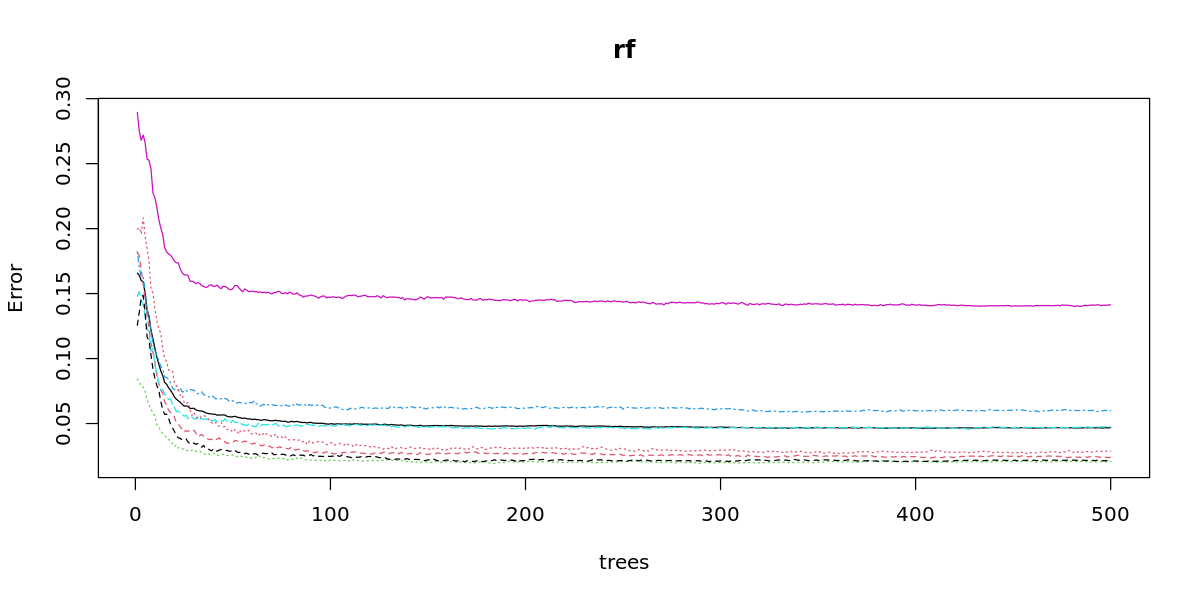

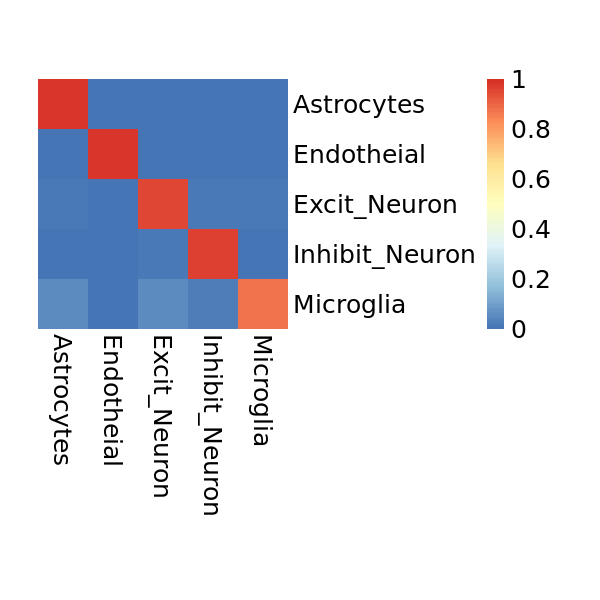

In [38]:
#rf = readRDS(paste0(dataDir, "/allSnRNAseq.soupx.mergeSeuratFiltlibFilt800mt5Ratio1d2.class.randomForest.20220822.rds"))
str(rf$confusion)
options(repr.plot.width=10, repr.plot.height=5)
plot(rf)

confusionRatio = t(apply(rf$confusion[1:5, 1:5], 1, function(x) {x/sum(x)}))
options(repr.plot.width=5, repr.plot.height=5)
pheatmap(confusionRatio, breaks=seq(0,1,0.01), cluster_rows=F, cluster_cols=F, border_color=NA, cellwidth=30, cellheight=30, fontsize=15)

 'matrix' num [1:325882, 1:7] 0.02 0 0.002 0 0.046 0.028 0.002 0.006 0.012 0.042 ...
 - attr(*, "dimnames")=List of 2
  ..$ : chr [1:325882] "2191-1_CELL6894_N1" "2191-1_CELL2974_N1" "2191-1_CELL39_N2" "2191-1_CELL4337_N1" ...
  ..$ : chr [1:7] "Astrocytes" "Endotheial" "Excit_Neuron" "Inhibit_Neuron" ...


cellId,maxPredClassScore,maxPredClass
<chr>,<dbl>,<chr>
2191-1_CELL6894_N1,0.596,Inhibit_Neuron
2191-1_CELL2974_N1,0.994,Inhibit_Neuron
2191-1_CELL39_N2,0.940,Excit_Neuron
2191-1_CELL4337_N1,0.968,Excit_Neuron
2191-1_CELL4465_N1,0.924,Inhibit_Neuron
2191-1_CELL2955_N1,0.842,Excit_Neuron


   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 0.1700  0.7440  0.9200  0.8224  0.9700  1.0000 

[1] TRUE

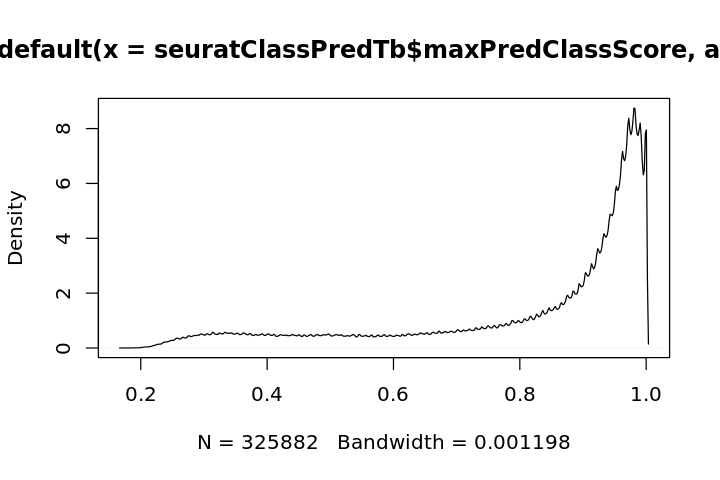

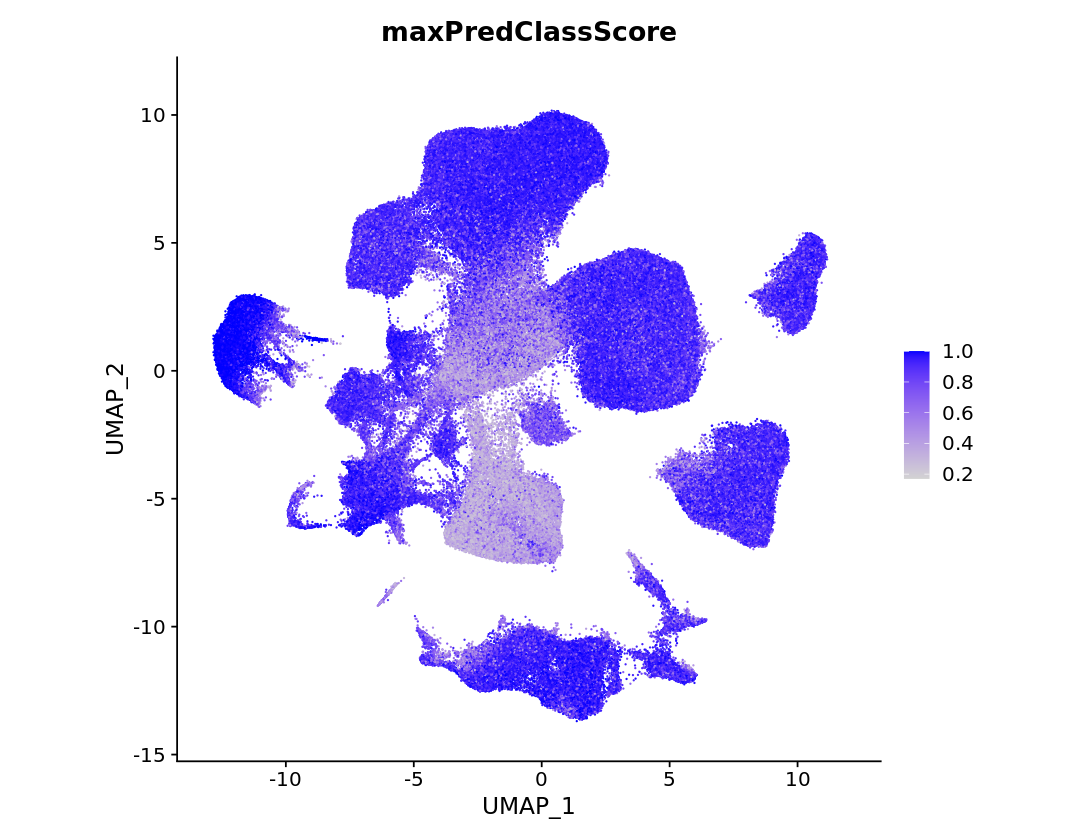

In [39]:
# Apply the trainer to filter cells
seuratCountDf = as.data.frame(t(as.matrix(seurat[["SCT"]]@data[unique(classMarker$gene), ])))
colnames(seuratCountDf) = paste0("col_", colnames(seuratCountDf))
colnames(seuratCountDf) = gsub("-", "_", colnames(seuratCountDf))
seuratClassPred = predict(rf, seuratCountDf, type="prob")
str(seuratClassPred)

seuratClassPredTb = tibble(
    cellId = rownames(seuratClassPred),
    maxPredClassScore = apply(seuratClassPred, 1, max),
    maxPredClass = apply(seuratClassPred, 1, function(x) {names(x)[which.max(x)]})
)
head(seuratClassPredTb)

summary(seuratClassPredTb$maxPredClassScore)
options(repr.plot.width=6, repr.plot.height=4)
plot(density(seuratClassPredTb$maxPredClassScore, adjust=0.1))

identical(seuratClassPredTb$cellId, rownames(seurat@meta.data))
tmpDf = as.data.frame(seuratClassPredTb[c("maxPredClassScore", "maxPredClass")])
rownames(tmpDf) = seuratClassPredTb$cellId

seurat = AddMetaData(seurat, tmpDf)

options(repr.plot.width=9, repr.plot.height=7)
FeaturePlot(seurat, reduction="umap", features="maxPredClassScore",raster=FALSE)+coord_fixed()


In [40]:
# Filter class outliers
# Removed clusters classified with ambiguous labels
# Removed cells classified with a different label from the majority of cells in its clusters
# Removed outliers when clustering, typically on the fringes of clusters in U-map space

Idents(seurat) = "seurat_clusters"
cellNum0 = ncol(seurat)
classFiltSeurat = subset(seurat, maxPredClassScore >= 0.8)
cellNum1 = ncol(classFiltSeurat)
message("Filt cell ratio: ", cellNum1/cellNum0)



Filt cell ratio: 0.704199679638642



In [41]:
classFiltSeurat

An object of class Seurat 
91558 features across 229486 samples within 2 assays 
Active assay: SCT (42850 features, 5000 variable features)
 1 other assay present: RNA
 2 dimensional reductions calculated: pca, umap